In [1]:
import pickle
from build_netmob_data import load_subway_shp,load_netmob_gdf,get_information_from_path
import torch
import pandas as pd
import os 
import sys
import glob
import numpy as np
# Obtenir le chemin du dossier parent
current_path = notebook_dir = os.getcwd()
# current_path = os.path.dirname()
working_dir = os.path.abspath(os.path.join(current_path, '..'))

# Ajouter le dossier parent au chemin de recherche des modules
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

In [2]:
# Init: 
data_folder_path = '../../../../data/'
save_folder = f"{data_folder_path}NetMob_tensor/"
netmob_data_folder_path = f"{data_folder_path}NetMob/"
PATH_iris = f'{data_folder_path}lyon_iris_shapefile/'
# Load Ref Subway: 
ref_subway = load_subway_shp(folder_path = data_folder_path)

# Parameters: size of netmob image 
step_south_north = 287  # Incremente by 287-ids when passing from south to north. 
epsilon=1000  #epsilon : radius, in meter (1000m) 
# W,H = 2*(epsilon//100 + 1), 2*(epsilon//100 + 1)
'''
Define the NetMob Geodatarame associated to Lyon City.
Build 'result' which keep track on tile-ids associated to each subway stations
'''
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Load subway gdf adn NetMob gdf
Netmob_gdf,working_zones = load_netmob_gdf(folder_path = netmob_data_folder_path,
                            data_folder = PATH_iris, 
                            geojson_path = 'Lyon.geojson',
                            zones_path = 'lyon.shp')
Netmob_gdf_dropped = Netmob_gdf.drop_duplicates(subset = ['tile_id'])  # Some Doubles are exis
#Netmob_gdf_dropped.explore()

In [110]:
def tackle_one_days_entire_map(txt_path,Lyon_ids,k0,kn,N,P,netmob_data_folder_path,app,day,transfer_mode,columns):
    #Read CSV
    txt_path = glob.glob(os.path.join(f'{netmob_data_folder_path}/{app}/{day}',f"*_{transfer_mode}.txt"))[0]
    transfer_mode,columns = get_information_from_path(txt_path)
    df = pd.read_csv(txt_path, sep = ' ', names = columns).set_index(['tile_id'])
    df = df.loc[Lyon_ids]
    
    k0,kn,N =get_windows_caracteristics(df)

    # Get df within rectangular window (filled with 0 when empty)
    new_df = df.reindex(np.arange(kn,k0,-1),fill_value=0)

    # Build Tensor
    T = torch.tensor(new_df.values, dtype = torch.int32)
    T = T.permute(1,0)
    T = T.reshape(T.size(0),N,P)
    return(T)
        
def find_N(km,kM,P = 287):
    ''' 
    args 
    ---------
    km,kM : tile_id min and tile_id max
    P: number of tiles per row
    
    outputs : 
    N : number of tiles per colum
    '''
    N = (kM-km)//P + 1  # N = N_ if  rest == 0
    
    # Particular case when kM < km + N_*P
    if (N != (kM-km)/P) and (kM < km + N*P):
        N = N + 1
            
    return N

def get_limits_tile_id(km,N,P):
    first_tile_id = (km//P)*P
    last_tile_id = first_tile_id+ N*P
    
    return first_tile_id,last_tile_id

def get_windows_caracteristics(df,P = 287):
    km,kM = df.index.min(),df.index.max()
    
    # Find limits (the window)
    N = find_N(km,kM,P)
    k0,kn = get_limits_tile_id(km,N,P)
    return(k0,kn,N)
        
if __name__ == '__main__':
    
    '''Looking to build the Tensor image associated to df. 
    The image dimension is [N,P]. 
    Between each row there is 287 Tile.
    '''
    
    transfer_mode = 'DL'
    Lyon_ids = Netmob_gdf_dropped.tile_id
    apps = [app for app in os.listdir(netmob_data_folder_path) if ((app != 'Lyon.geojson') and (not app.startswith('.'))) ]   # Avoid hidden folder and Lyon.geojson


    # For each app
    T_apps = []
    import time
    
    t0 = time.time()
    for app in apps: 
        T_days = []
        folder_days = [day for day in os.listdir(f'{netmob_data_folder_path}/{app}') if (not day.startswith('.'))] 
        for day in folder_days:
            T = tackle_one_days_entire_map(txt_path,Lyon_ids,k0,kn,N,P,netmob_data_folder_path,app,day,transfer_mode,columns)
            T_days.append(T)
        T_days = torch.cat(T_days)
        T_apps.append(T_days)
    T_apps = torch.stack(T_apps,dim=0)
    print('T_apps: ', T_apps.size(),'time: ', time.time()-t0)

T_apps:  torch.Size([68, 7392, 263, 287]) time:  1734.4786126613617


In [115]:
name_save = 'NetMob_DL_video_Lyon'
save_path = '../../../../data'

torch.save(T_apps,f"{save_path}/{name_save}.pt")
pickle.dump(apps,open(f"{save_path}/{name_save}_APP.pkl",'wb'))

In [2]:
import torch 

name_save = 'NetMob_DL_video_Lyon'
save_path = '../../../../data'

T_test = torch.load(f"{save_path}/{name_save}.pt")
T_test.size()

torch.Size([68, 7392, 263, 287])

# Filtrage de donnée : 

In [119]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Set3
def plot_bokeh(df, columns = None, title = ''):
    colors = Set3[12]
    # Activer l'affichage dans le notebook
    output_notebook()

    # Créer la source de données Bokeh
    source = ColumnDataSource(df)

    # Créer la figure
    p = figure(title=title, x_axis_label='time-slots', y_axis_label='Valeur', width=800)
    # Ajouter les courbes
    if columns is None:
        columns = df.columns
    for k,c in enumerate(columns):
        color = colors[2+k]
        p.line(x='index', y=c, source=source,color = color, legend_label=c, line_width=2)

    # Afficher la légende
    p.legend.location = "top_left"

    # Afficher le graphique
    show(p)

### Filtre Median 

(0.0, 300000.0)

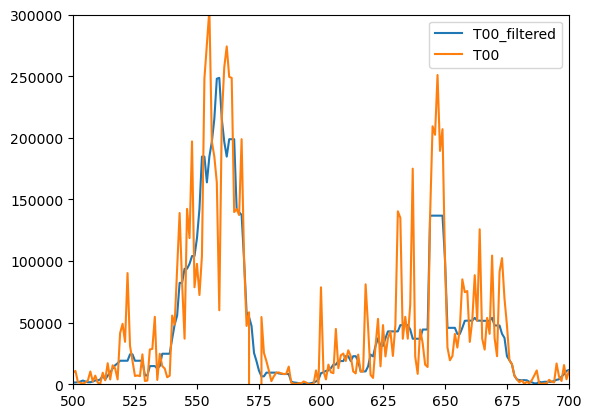

In [120]:
from scipy.signal import medfilt
import matplotlib.pyplot as plt
T00 = T_test[0,:,150,150]
T00_np = T00.numpy()
T00_filtered_np = medfilt(T00_np, kernel_size=11)
T00_filtered = torch.from_numpy(T00_filtered_np)

df = pd.DataFrame({'T00_filtered':T00_filtered,
             'T00':T00})
df.plot()
plt.xlim([500,700])
plt.ylim([0,300000])

In [121]:
plot_bokeh(df, title = 'T00 vs first filter')

Loading BokehJS ...

### Outliers par Z-score: 

In [123]:
def rec_start_ind(start, indices, end = None):
    # Init 
    if len(indices) == 0:
        if end is not None:
            return [[start,end]]
        else:
            return [[start,start]]
    
    else: 
        if end is None:
            # Si les indices se suivent d'un incrément de 1
            if indices[0] == start+1:
                return rec_start_ind(start, indices[1:], end = indices[0])

            # Sinon : 
            else:
                return [[start,start]] + rec_start_ind(indices[0], indices[1:], end = None)
        else:
            # Si les indices se suivent d'un incrément de 1
            if indices[0] == end+1:
                return rec_start_ind(start, indices[1:], end = indices[0])
            # Sinon :
            else:
                return [[start,end]] + rec_start_ind(indices[0], indices[1:], end = None)

Outliers:  tensor([572, 573, 574, 575])


(-100000.0, 300000.0)

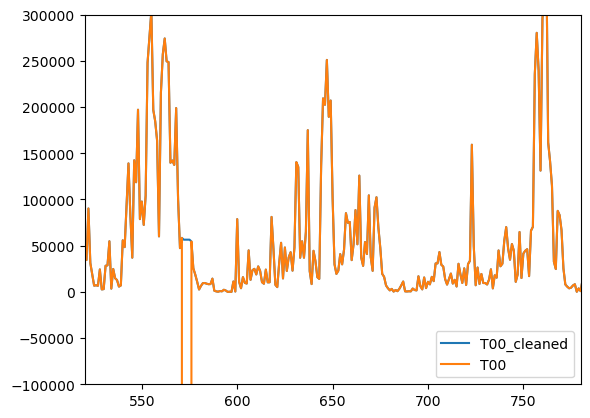

In [125]:
def z_score_outlier_inputing(T00,threshold = 3):
    # Calculer la moyenne et l'écart-type
    mean = torch.mean(T00)
    std = torch.std(T00)
    z_scores = (T00 - mean) / std 
    outliers = torch.abs(z_scores) > threshold

    # Remplacer les outliers par la moyenne de leurs voisins
    T00_cleaned = T00.clone()
    indices = outliers.nonzero(as_tuple=True)[0]
    indices = indices.sort().values
    print('Outliers: ',indices)
    start_end_outliers = rec_start_ind(indices[0], indices[1:], end = None) 

    for start,end in start_end_outliers:
        if (0 < start) and (end  < len(T00) - 1):
            T00_cleaned[start:end+1] = (T00[start - 1] + T00[end + 1]) / 2
        elif start == 0:
            T00_cleaned[start] = T00[end + 1]
        else:
            T00_cleaned[start] = T00[start - 1]
    return T00_cleaned

T00_cleaned = z_score_outlier_inputing(T00,threshold = 3)
df = pd.DataFrame({'T00_cleaned':T00_cleaned,
             'T00':T00})
df.plot()
plt.xlim([520,780])
plt.ylim([-100000,300000])      

In [126]:
plot_bokeh(df, title = 'T00 vs Z-score filter ')

Loading BokehJS ...

In [128]:
T00_cleaned2 = z_score_outlier_inputing(T00_cleaned,threshold = 5)
df = pd.DataFrame({'T00_cleaned':T00_cleaned,
             'T00_cleaned2':T00_cleaned2})
plot_bokeh(df, title = 'T00 cleaned vs second cleaning ')

Outliers:  tensor([ 554,  555,  562,  757,  760,  761,  762,  851, 1427, 1701, 1811, 4088,
        4702, 4703, 4888, 4889, 4986, 5366, 5371, 5375, 5446, 5447, 5448, 5940,
        5941, 6203, 6204, 6207, 6208, 6216, 6228, 6229, 6230, 6234, 7283, 7284,
        7285, 7350])


Loading BokehJS ...

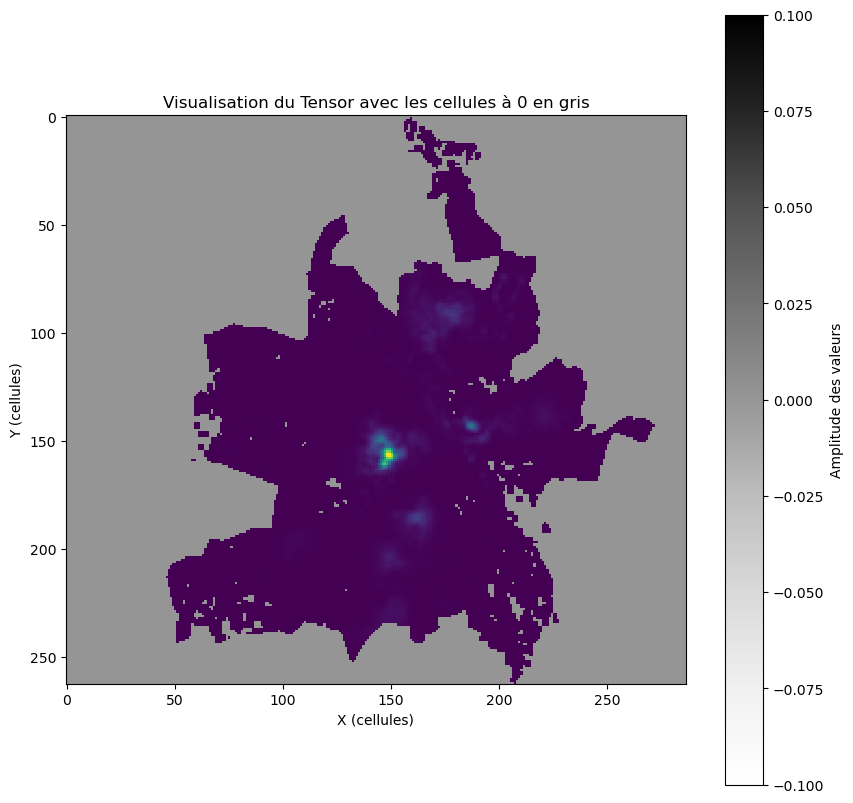

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors



def plot_instant_on_map(T00):
    # Créer un masque pour les cellules avec des valeurs non-nulles
    mask_zero = (T00 == 0)

    # Créer une figure et un axe
    plt.figure(figsize=(10, 10))

    # Afficher les cellules non nulles avec la colormap viridis
    cmap = plt.cm.viridis
    norm = mcolors.Normalize(vmin=T00[T00 > 0].min().item(), vmax=T00.max().item())

    # Afficher les cellules avec des valeurs non-nulles
    plt.imshow(np.ma.masked_where(T00 == 0, T00), cmap=cmap, norm=norm, origin='upper', interpolation='none')

    # Afficher les cellules contenant 0 en gris
    plt.imshow(np.ma.masked_where(T00 != 0, T00), cmap=plt.cm.Greys, origin='upper', interpolation='none')

    # Ajouter une barre de couleurs pour les cellules non nulles
    plt.colorbar(label='Amplitude des valeurs')

    # Ajouter un titre et des labels
    plt.title('Visualisation du Tensor avec les cellules à 0 en gris')
    plt.xlabel('X (cellules)')
    plt.ylabel('Y (cellules)')

    # Afficher le graphique
    plt.show()
    
    
T00 = T_test[0,7*4,:,:]
plot_instant_on_map(T00)

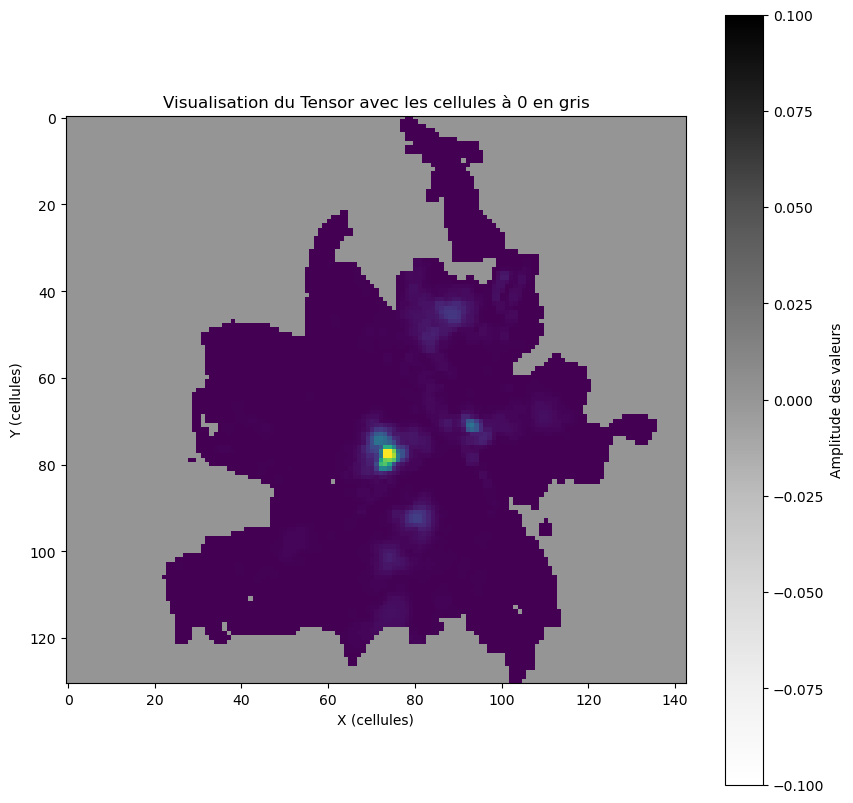

In [4]:
T00 = T_test[:1,7*4,:,:].float()
kernel_size = (3,3)
stride = (2,2)
padding = 0
agvpool = torch.nn.MaxPool2d(kernel_size, stride, padding)
T00_pooled = agvpool(T00).squeeze()

plot_instant_on_map(T00_pooled)

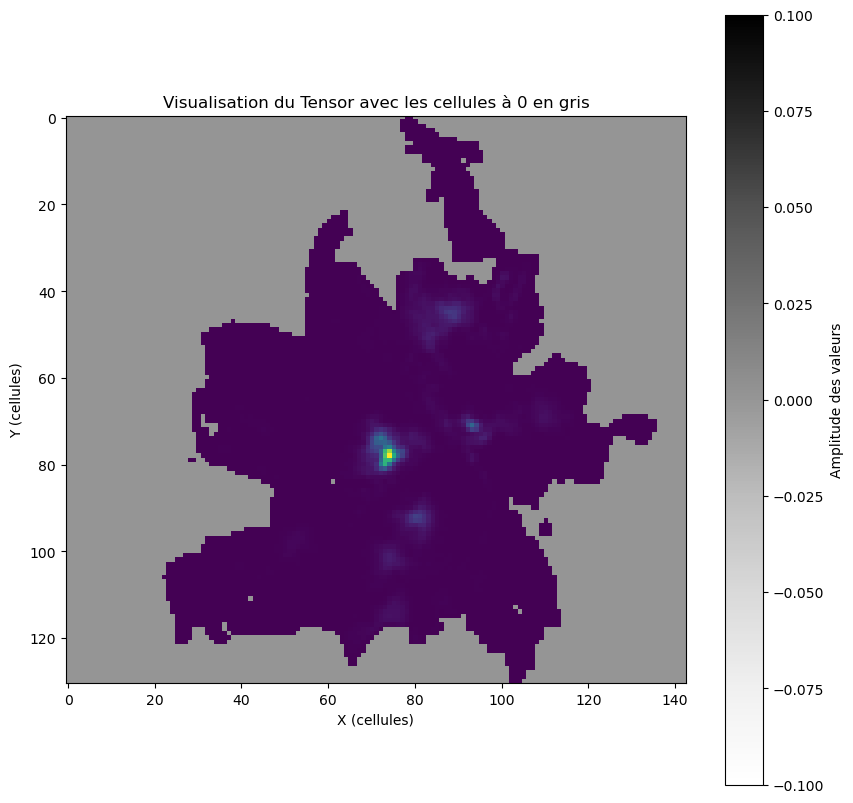

In [4]:
T00 = T_test[:1,7*4,:,:].float()
kernel_size = (3,3)
stride = (2,2)
padding = 0
agvpool = torch.nn.AvgPool2d(kernel_size, stride, padding)
T00_pooled = agvpool(T00).squeeze()

plot_instant_on_map(T00_pooled)

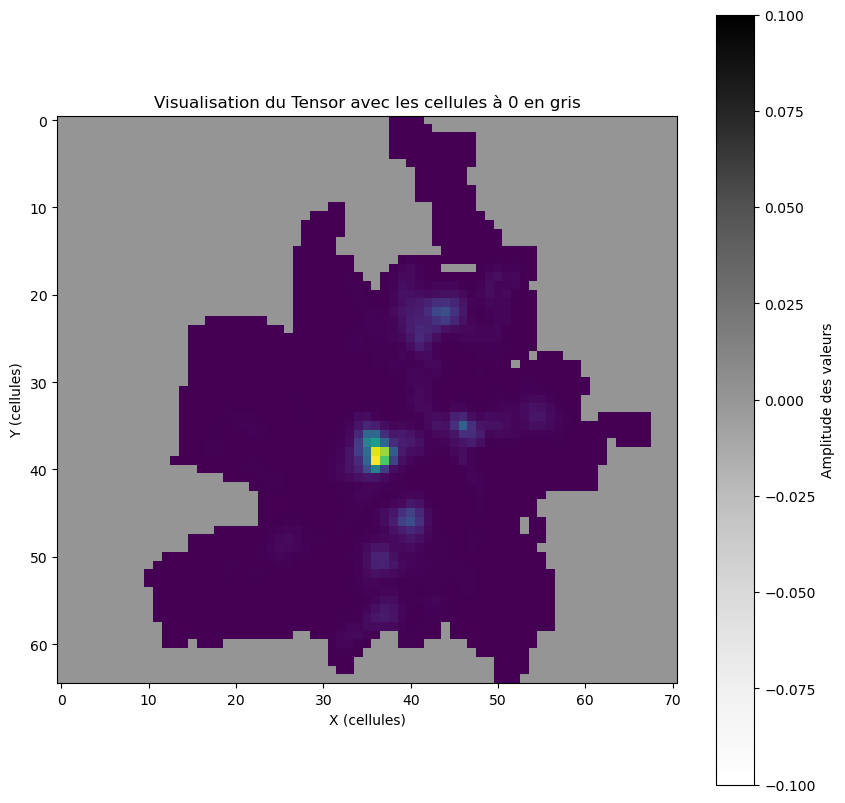

In [6]:
T00_pooled2 = agvpool(T00_pooled.unsqueeze(0)).squeeze()
plot_instant_on_map(T00_pooled2)